In [67]:
import matplotlib.pyplot as plt
import numpy as np

from pycalphad import Database, equilibrium, calculate, binplot
from pycalphad import variables as v
from pycalphad.plot.utils import phase_legend

import warnings
import datetime
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm # да, пока что pymc3, я в процессе перехода на pymc тк никаких расчетов с sample делать пока не приходилось
import theano.tensor as tt

warnings.simplefilter(action="ignore", category=FutureWarning)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
print(f"Running on PyMC3 v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")

In [70]:
сс10 = "tdbs/CoCr-01Oik.tdb"
сс18 = "tdbs/CoCr-18Cac.tdb"

In [30]:
def bin_plot(db, elements, el_cnt): # можно добавить кол-во графиков
    phases = list(db.phases.keys())
    
    fig = plt.figure(figsize=(9,6))
    axes = fig.gca()
    
    binplot(db, elements, phases, {v.X(elements[0]):(0,1,0.02), v.T: (200, 1800, 10), v.P:press, v.N: el_cnt}, plot_kwargs={'ax': axes})
    
    plt.show()

In [71]:
db10 = Database(сс10)
db18 = Database(сс18)

phases10 = list(db10.phases.keys())
phases18 = list(db18.phases.keys())
press = 101325
elements = ['CR', 'CO', 'VA']
el_cnt = 1

#### Суть эксперимента
1. Мы берем две базы данных, в которых по-разному определяется sigma-фаза
2. Далее, мы выбираем две концентрации CR: первая находится в двухфазной области sigma и fcc (0.5), вторая в области sigma и bcc (0.8)
3. Таким образом, мы можем для каждой температуры в этой двухфазной области для каждой фазы можем определить химический состав
4. Следовательно сравнивать химический состав стабильных фаз для каждой температуры: по эмпирическим данным и по данным, рассчитанным с помощью equlibrium

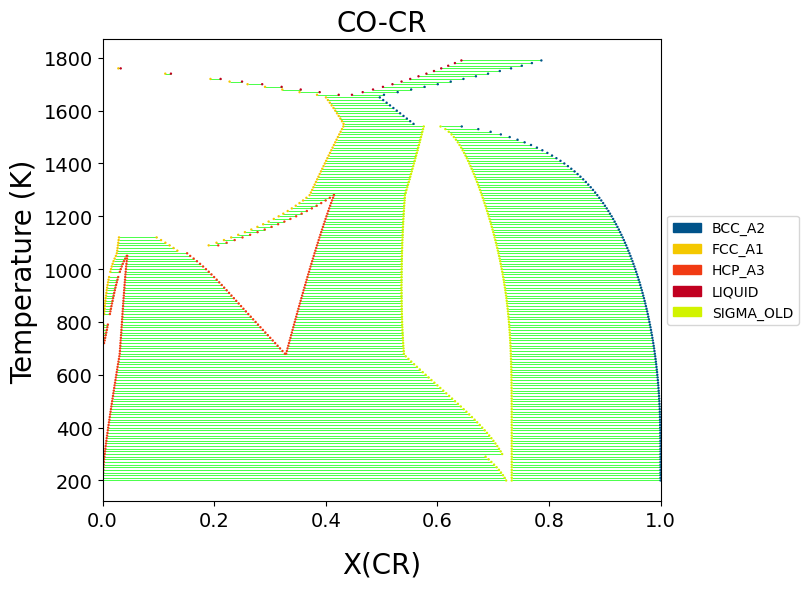

In [32]:
bin_plot(db10, ['CR', 'CO', 'VA'], 1)

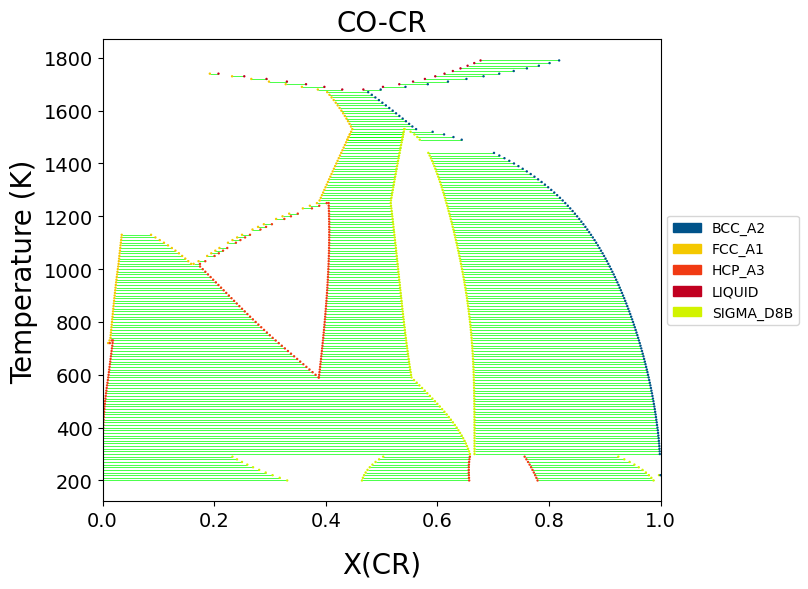

In [72]:
bin_plot(db18, ['CR', 'CO', 'VA'], 1)

Двухфазные области существуют при:
1. $CR = 0.5, T \in \{x;y\}$ соответсвуют фазам $(SIGMA\_OLD, FCC\_A1)$
2. $CR = 0.8, T \in \{m;n\}$ соответсвуют фазам $(SIGMA\_OLD, BCC\_A2)$

#### Посмотрим, где хранится информация о химическом составе фазы

In [45]:
conditions = {v.X('CR'):0.5, v.P: 101325, v.T: (800, 1750, 1), v.N: el_cnt}
tets_calc = equilibrium(db10, elements, phases10, conditions)

In [46]:
tets_calc

<xarray.Dataset>
Dimensions:    (N: 1, P: 1, T: 950, X_CR: 1, vertex: 3, component: 2, internal_dof: 4)
Coordinates:
  * N          (N) float64 1.0
  * P          (P) float64 1.013e+05
  * T          (T) float64 800.0 801.0 802.0 ... 1.747e+03 1.748e+03 1.749e+03
  * X_CR       (X_CR) float64 0.5
  * vertex     (vertex) int32 0 1 2
  * component  (component) <U2 'CO' 'CR'
Dimensions without coordinates: internal_dof
Data variables:
    NP         (N, P, T, X_CR, vertex) float64 0.1917 0.8083 nan ... 1.0 nan nan
    GM         (N, P, T, X_CR) float64 -3.428e+04 -3.433e+04 ... -1.05e+05
    MU         (N, P, T, X_CR, component) float64 -3.354e+04 ... -9.28e+04
    X          (N, P, T, X_CR, vertex, component) float64 0.6555 0.3445 ... nan
    Y          (N, P, T, X_CR, vertex, internal_dof) float64 0.6555 ... nan
    Phase      (N, P, T, X_CR, vertex) <U9 'HCP_A3' 'SIGMA_OLD' '' ... '' ''
Attributes:
    engine:   pycalphad 0.10.1
    created:  2023-03-10T11:32:15.621323

#### Вывод:
Полезные для нас структуры:
1. Phase - строковое имя каждой равновесной фазы при заданных условиях
1. NP - фазовая доля каждой фазы в равновесии
2. MU - хим. потенциал каждого компонента для данных условий
3. X - состав каждого элемента в каждой фазе для расчетных условий (в равновесии)

**Собственно, X хранит те значения, к-е мы и будем сравнивать с экспериментальными.**

<u>Осталось на рссмотрении:</u>
как выводить эти данные в переменную?

ист: https://pycalphad.org/docs/latest/examples/UsingCalculationResults.html

#### Как реализовать замену параметров чз parameters?

In [87]:
conditions = {v.X('CR'):0.5, v.P: 101325, v.T: (800, 1750, 100), v.N: el_cnt}

###### Тест 1

In [88]:
parameters = {'GHSERCO': {'P': 101325, 'H0': -20000, 'S0': 50}}
test_y = equilibrium(db10, elements, phases10, conditions, parameters=parameters)

TypeError: float() argument must be a string or a number, not 'dict'

###### Тест 2

In [90]:
parameters = {'GFCCCO': 1, 'GHSERCR': 1,'GBCCCO': 1}
test_y = equilibrium(db10, elements, phases10, conditions, parameters=parameters)
test_y

<xarray.Dataset>
Dimensions:    (N: 1, P: 1, T: 10, X_CR: 1, vertex: 3, component: 2, internal_dof: 4)
Coordinates:
  * N          (N) float64 1.0
  * P          (P) float64 1.013e+05
  * T          (T) float64 800.0 900.0 1e+03 1.1e+03 ... 1.5e+03 1.6e+03 1.7e+03
  * X_CR       (X_CR) float64 0.5
  * vertex     (vertex) int32 0 1 2
  * component  (component) <U2 'CO' 'CR'
Dimensions without coordinates: internal_dof
Data variables:
    NP         (N, P, T, X_CR, vertex) float64 1.0 nan nan 1.0 ... 1.0 nan nan
    GM         (N, P, T, X_CR) float64 -2.051e+04 -2.406e+04 ... -5.867e+04
    MU         (N, P, T, X_CR, component) float64 -3.718e+04 ... -5.146e+03
    X          (N, P, T, X_CR, vertex, component) float64 0.5 0.5 ... nan nan
    Y          (N, P, T, X_CR, vertex, internal_dof) float64 0.5 0.5 ... nan nan
    Phase      (N, P, T, X_CR, vertex) <U9 'HCP_A3' '' '' ... 'LIQUID' '' ''
Attributes:
    engine:   pycalphad 0.10.1
    created:  2023-03-10T11:45:25.956980

###### Тест 3

In [97]:
ar = np.arange(800, 1750, 100)
ar_list = [i for i in ar]
ar_list

[800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700]

In [98]:
parameters = {'GFCCCO': ar_list, 'GHSERCR': ar_list,'GBCCCO': ar_list}
test_y = equilibrium(db10, elements, phases10, conditions, parameters=parameters)

ValueError: 'points' is not in list

###### Тест 4

In [99]:
parameters = {"G(SIGMA_OLD,CO:CR:CO)": 1, 'G(SIGMA_OLD,CO:CR:CR)': 1}
test_y = equilibrium(db10, elements, phases10, conditions, parameters=parameters)

KeyError: G(SIGMA_OLD,CO:CR:CO)

###### Тест 5

In [101]:
parameters = {'G': 1}
test_y = equilibrium(db10, elements, phases10, conditions, parameters=parameters)

KeyError: G

#### Вывод
<u>И тут мне становится непонятно<u>

Насколько я понимаю, идея была в том, чтобы распределение параметров, которые обозначены PAR в tdb, задать нормальным в pymc вокруг какого-то среднего, затем переопределить распределение этих параметров в equilibrium, и получить на выходе распределение для расчета апостериорной вероятности

Но:
1. у меня не получается сделать так, чтобы parameters увидел эти параметры,\
тут либо я что-то делаю не так, либо это нельзя сделать
2. передать распредление (типа list) для переопределния не получается, вероятно нужно использовать значение того среднего, вокруг к-го мы строим нормальное распределение

По итогу удалось переопредлить только модели, но это как-то некорректно
    
*Выдержка из документации:\
parameters (dict, optional) – Maps SymEngine Symbol to numbers, for overriding the values of parameters in the Database.*

ист: https://pycalphad.org/docs/latest/api/pycalphad.core.html?highlight=equilibrium#module-pycalphad.core.equilibrium

#### Тестовый прогон расчета правдоподобия

In [66]:
сс10_model = pm.Model()
T = np.arange(298.15, 1680, 0.1)
with сс10_model as model:
    
    # распределение нулевого члена
    # среднее взяла за 0, потому что пока не понимаю, что именно брать за среднее, с дисперсией аналогично
    GFCCCO_N = pm.Normal("GFCCCO_N", mu=0, sigma=1)
    GHSERCR_N = pm.Normal("GHSERCR_N", mu=0, sigma=1)
    GBCCCO_N = pm.Normal("GBCCCO_N", mu=0, sigma=1)
    
    y_emp =  pm.Normal("y_emp", mu=0, sigma=1)
    
    # распределение параметров
    # g_oro = g_oid_oro - 103863 + 47.47 * T
    # g_orr = g_oid_orr - 248108.8 + 79.12 * T
    
    # задали распределение результирующих значений модели на основании новых распределений параметров
    conditions = {v.X('CR'):0.5, v.P: 101325, v.T: (800, 1750, 1), v.N: el_cnt}
    parameters_N = {'GFCCCO': GFCCCO_N, 'GHSERCR':  GHSERCR_N,'GBCCCO': GBCCCO_N}
    y_eval = equilibrium(db10, elements, phases10, conditions, parameters = parameters_N)
    
    # посчитали правдоподобие модели
    y_obs = pm.Normal("y_obs", mu=y_eval, observed=y_emp)

    # посчитали апостериорное распределение
    # trace = pm.sample(1000, tune=1000)

ValueError: setting an array element with a sequence.

In [ ]:
сс10_model = pm.Model()
T = np.arange(298.15, 1680, 0.1)
with сс10_model as model:
    
    # распределение нулевого члена
    # среднее взяла за 0, потому что пока не понимаю, что именно брать за среднее, с дисперсией аналогично
    g_oid_oro = pm.Normal("g_oid_oro", mu=0, sigma=1)
    g_oid_orr = pm.Normal("g_oid_orr", mu=0, sigma=1) 
    
    # распределение параметров
    g_oro = g_oid_oro - 103863 + 47.47 * T
    g_orr = g_oid_orr - 248108.8 + 79.12 * T
    
    # задали распределение результирующих значений модели на основании новых распределений параметров
    conditions = {v.X('CR'):0.5, v.P: 101325, v.T: (800, 1750, 1), v.N: el_cnt}
    parameters = {'ALCU_MG_VA': {'P': 101325, 'H0': -20000, 'S0': 50}
                 ,}
    y_eval = equilibrium(db10, elements, phases10, conditions)
    
    # посчитали правдоподобие модели
    y_obs = pm.Normal("y_obs", mu=y_eval, observed=y_emp)

    # посчитали апостериорное распределение
    # trace = pm.sample(1000, tune=1000)

#### Итог
Тут вопросов больше, чем ответов

Непонятно:

1. Какие параметры мы переопределяем?\
Раз мы делаем расчеты для двухфазной области, для к-й в tdb нет модели, а только параметры, логично, что это те величины, к-е обозначены как PAR\
Но как до них добраться через parameters?
2. Как правильно задать распределение параметра?\
В случае с cc10 у нас всего два параметра, каждый из которых можно представить по схеме:\
$$g^0 + g^{id} +  g^{ex}$$
$g^0 + g^{id}$ - нулевой член, $g^{ex}$ - избыточная энергия гиббса смешения

<u>Но вопросы:</u>
1. Если мы переопредляем целый параметр, то он должен быть хотя бы немного близким, к тем значениям, которые он реально выдает в бд?\
2. Как этого достичь?\
Если просто задать нормальное распределение нулевому члену и прибавить к нему $g^{ex}$ то получится какое-то распределение, но какое - зависит от mu, которое будет задано.
3. Почему мы полагаем, что все параметры распределены нормлаьно?